# TP 1

### import libraries 

In [17]:
import os
import powerlaw          as pl

import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
from matplotlib.ticker   import PercentFormatter
from  scipy.stats        import norm,expon,weibull_min
from  scipy.optimize     import curve_fit

### import data

In [18]:

folder_path = 'Data/BNPP.PA'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and 'trades' in f]

df_trades = pd.DataFrame()
for f in file_names:
    gzip_file_path = folder_path+'/'+f
    df = pd.read_csv(gzip_file_path, compression='gzip',index_col=None)
    del df['Unnamed: 0']
    df['ts'] = pd.to_datetime(df['ts'])
    df_trades = pd.concat([df_trades,df])

df_trades.tail(5)

,ts,price,volume
16628,2017-01-31 17:29:55.411,59.42,5.0
16629,2017-01-31 17:29:55.411,59.42,32.0
16630,2017-01-31 17:29:57.051,59.42,66.0
16631,2017-01-31 17:29:57.051,59.41,261.0
16632,2017-01-31 17:29:57.051,59.41,267.0


### Question I

#### 1. Price and ticksize

1-1. Plot the evolution of the transaction price on the full sample

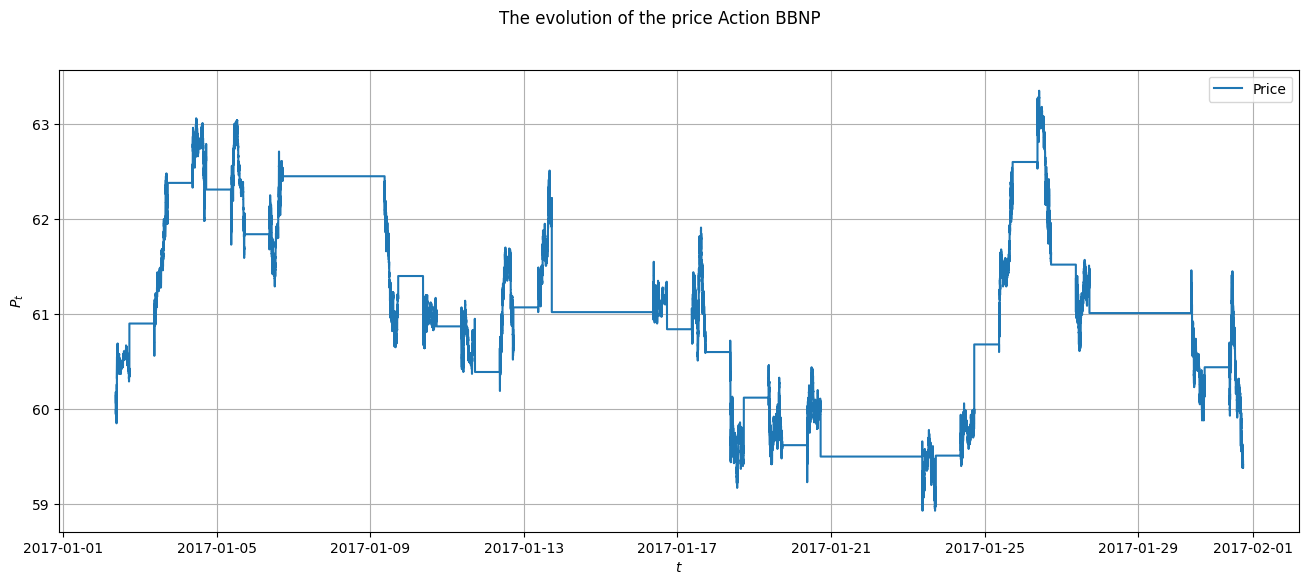

In [19]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of the price Action BBNP')

ax.step(df_trades['ts'],df_trades['price'],label=r'Price')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$P_t$')
ax.grid()
ax.legend()

plt.show()

* Comments
    - We notice that the price is the same at the end of the weeek.
    - Over a month the price is between Low = 59 and High = 63
    - we notice big price jumps on the 3rd, 18th, 25th, and 26th on Juanary 2017
    - we notice that usually there are two jsmall jumps per day (*Open* and *Closing* moments) which can be explain by the price converging the optimal price 

1-2. Plot the evolution of the transaction price on a subset of a few minutes

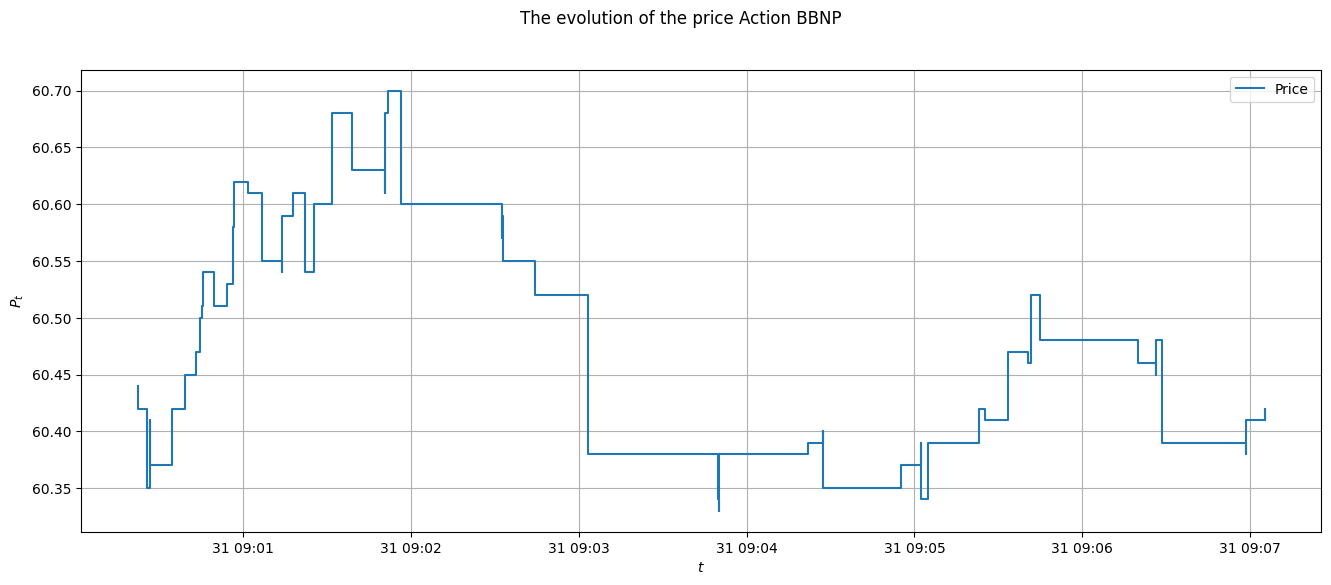

In [20]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of the price Action BBNP')

ax.step(df['ts'].iloc[:200],df['price'].iloc[:200],label=r'Price')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$P_t$')
ax.grid()
ax.legend()

plt.show()

* Comments
    - in the plot above we plot the evolution of the price during 7 min on the 31th of January.
    - we notice the presence of small jumps and begger jumps. Usually the sammler jumps correspend to moving from a bid/ask order to an other 

1.3 Measure the ticksize

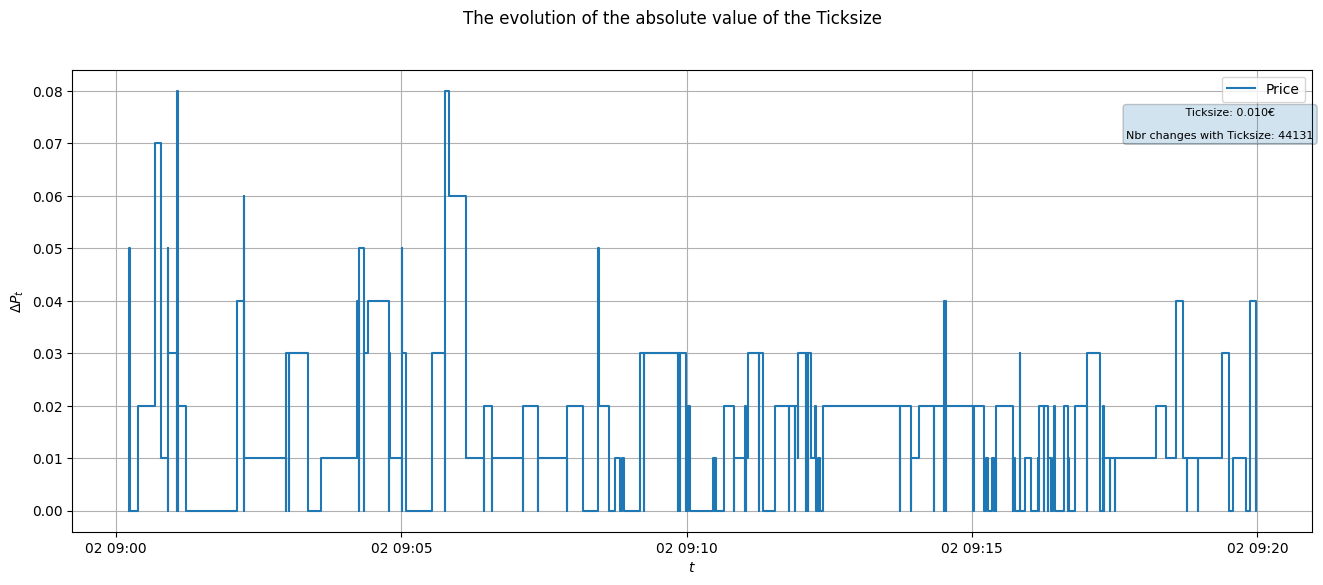

In [21]:
df_ticksize = df_trades.copy()
df_ticksize['ticksize'] =  (df_ticksize['price'] - df_ticksize['price'].shift(1)).abs()

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of the absolute value of the Ticksize')

ax.step(df_ticksize['ts'].iloc[:500],df_ticksize['ticksize'].iloc[:500],label=r'Price')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta P_t$')
ax.grid()
ax.legend()
ticksize = df_ticksize[((df_ticksize["ticksize"]>0) & ~df_ticksize["ticksize"].isna())]["ticksize"].min()
textstr = f'''                 Ticksize: {ticksize:.3f}€
            \nNbr changes with Ticksize: {len(df_ticksize[df_ticksize["ticksize"] == ticksize])}'''

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', alpha=0.2)

# place a text box in upper left in axes coords
ax.text(0.85, 0.85, textstr, transform=ax.transAxes, fontsize=8,bbox=props)

plt.show()

* Comments
    - The stock value is >50€ then the ticksize in the Euronext trading rules is 0.01€
    - We respect the agreement
    - this happened more then 44 000 times during 20 min

#### 2. Trade durations

2.1 Plot an histogram of the empirical density of the trade durations, in linear and log-log scale.

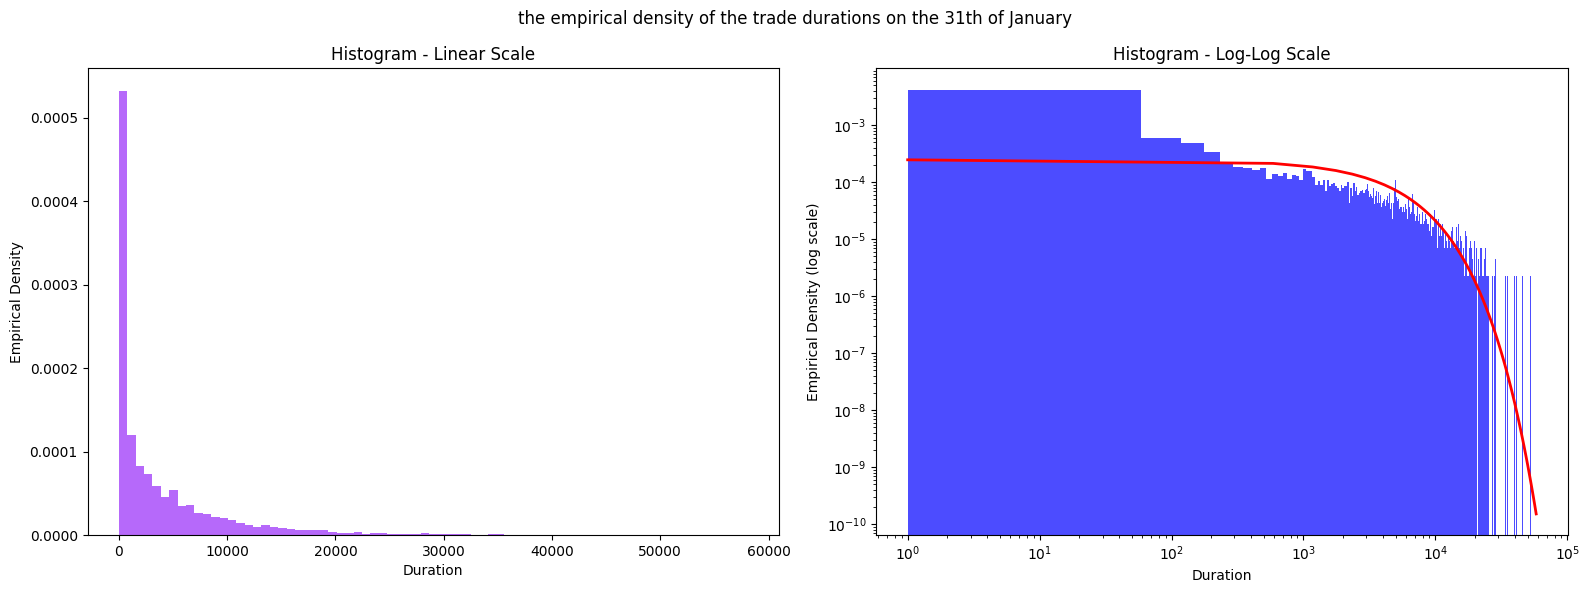

In [22]:
df_duration = pd.DataFrame({'ts':df['ts'].unique()})
df_duration['duration'] = df_duration['ts'] - df_duration['ts'].shift(1)
df_duration.dropna(inplace=True)
df_duration['duration'] =   (df_duration['duration'].astype('int64') / 10**6).astype('int64')
Duration = df_duration['duration'].values


fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle(r'the empirical density of the trade durations on the 31th of January')


ax[0].hist(Duration, bins=75, density=True, color='#972AF8', alpha=0.7)
ax[0].set_title('Histogram - Linear Scale')
ax[0].set_xlabel('Duration')
ax[0].set_ylabel('Empirical Density')


params= expon.fit(Duration)
xmin, xmax = np.min(Duration), np.max(Duration)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

ax[1].hist(Duration, bins=1000, density=True, log=True, color='blue', alpha=0.7)
ax[1].plot(x, p, linewidth=2,color='red',label=' exponential fit')
ax[1].set_xscale('log')
ax[1].set_title('Histogram - Log-Log Scale')
ax[1].set_xlabel('Duration')
ax[1].set_ylabel('Empirical Density (log scale)')

plt.tight_layout()
plt.show()

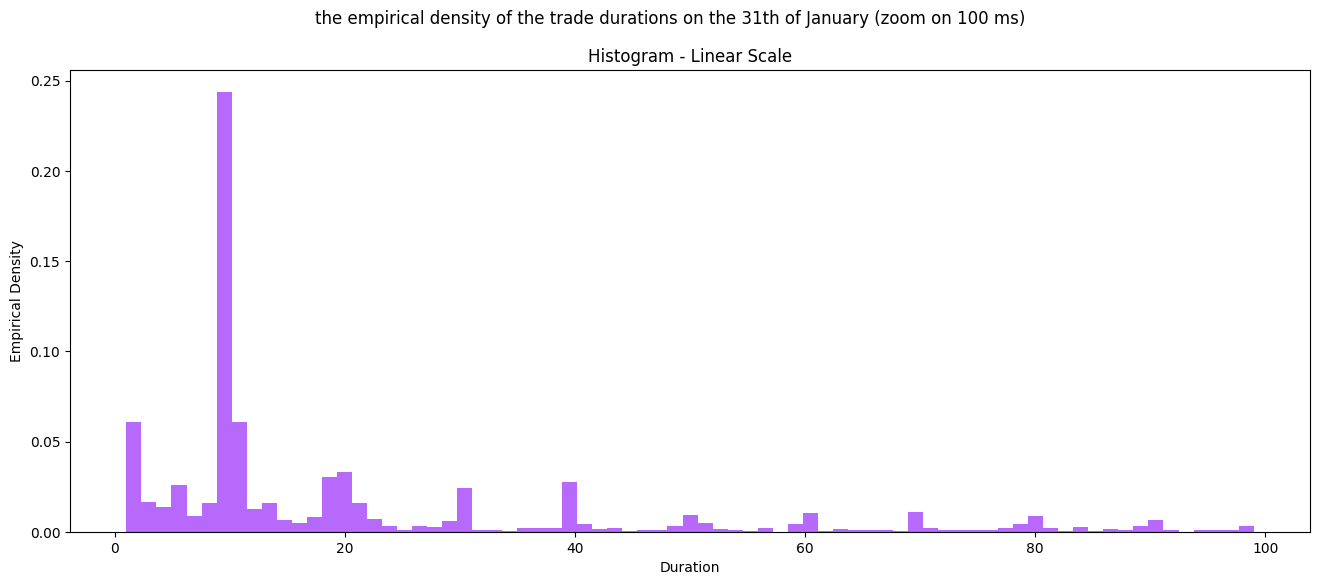

In [23]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the trade durations on the 31th of January (zoom on 100 ms)')


ax.hist(Duration[Duration < 100], bins=75, density=True, color='#972AF8', alpha=0.7)
ax.set_title('Histogram - Linear Scale')
ax.set_xlabel('Duration')
ax.set_ylabel('Empirical Density')
plt.show()

2.4 [4] rejects the hypothesis that a power law is a good fit of the duration distribution, but finds
that Weibull distributions can be good candidates.

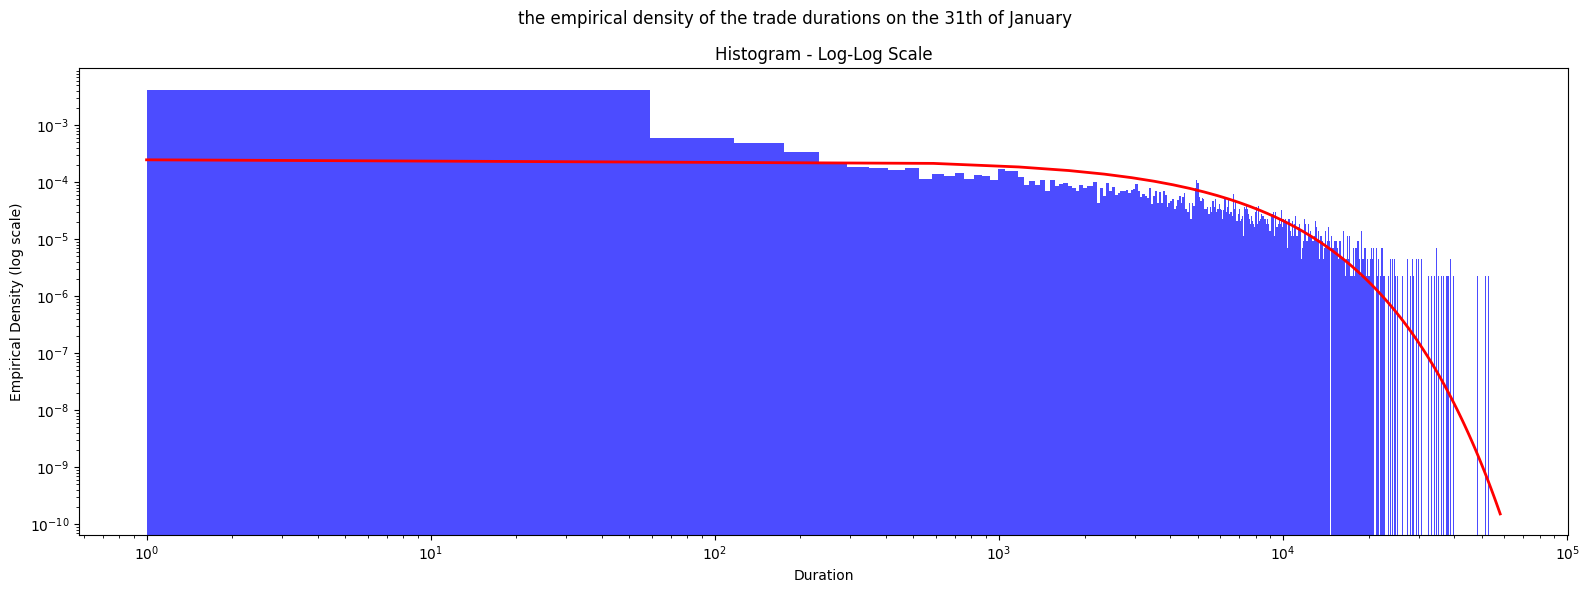

In [24]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the trade durations on the 31th of January')

params= expon.fit(Duration)
xmin, xmax = np.min(Duration), np.max(Duration)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

ax.hist(Duration, bins=1000, density=True, log=True, color='blue', alpha=0.7)
ax.plot(x, p, linewidth=2,color='red',label=' exponential fit')
ax.set_xscale('log')
ax.set_title('Histogram - Log-Log Scale')
ax.set_xlabel('Duration')
ax.set_ylabel('Empirical Density (log scale)')

plt.tight_layout()
plt.show()

Calculating best minimal value for power law fit
C:\Users\mohamed iyadh laouej\AppData\Roaming\Python\Python39\site-packages\powerlaw.py:692: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


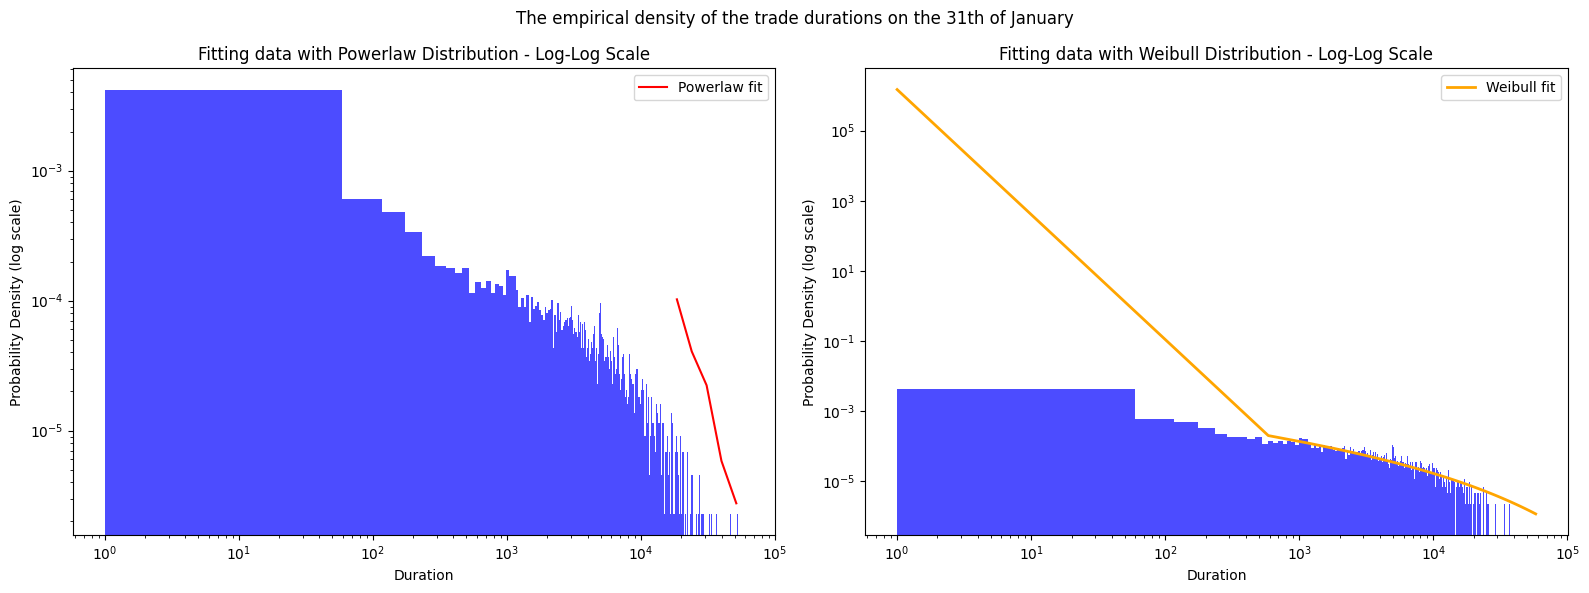

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(r'The empirical density of the trade durations on the 31th of January')

# Fitting with Powerlaw distribution
fit = pl.Fit(Duration)
fit.plot_pdf(color='red', ax=ax[0],label='Powerlaw fit')
ax[0].hist(Duration, bins=1000, density=True, log=True, color='blue', alpha=0.7)
ax[0].set_xscale('log')
ax[0].set_title('Fitting data with Powerlaw Distribution - Log-Log Scale')
ax[0].set_xlabel('Duration')
ax[0].set_ylabel('Probability Density (log scale)')
ax[0].legend()


# Fitting with Weibul distribution
params_weibull = weibull_min.fit(Duration)
xmin, xmax = np.min(Duration), np.max(Duration)
x_weibull = np.linspace(xmin, xmax, 100)
pdf_weibull = weibull_min.pdf(x_weibull, *params_weibull)

ax[1].hist(Duration, bins=1000, density=True, log=True, color='blue', alpha=0.7)
params_weibull = weibull_min.fit(Duration)
p_weibull = weibull_min.pdf(x, *params_weibull)
ax[1].plot(x, p_weibull, linewidth=2, color='orange', label='Weibull fit')
ax[1].set_xscale('log')
ax[1].set_title('Fitting data with Weibull Distribution - Log-Log Scale')
ax[1].set_xlabel('Duration')
ax[1].set_ylabel('Probability Density (log scale)')
ax[1].legend()

plt.tight_layout()
plt.show()



We see that a powerlaw distribution fails to fit the data opposite to a Weibull distribution which fits well the data especially the tail of the distribution.

### Question II

#### 3. Trade volumes

3.1 Plot a histogram of the empirical density of the trade sizes, in both linear and log-log scale
3.2 Add an exponential fit to the log-log histogram.
3.3 Add a power-law fit of the tail of the distribution to the log-log histogram

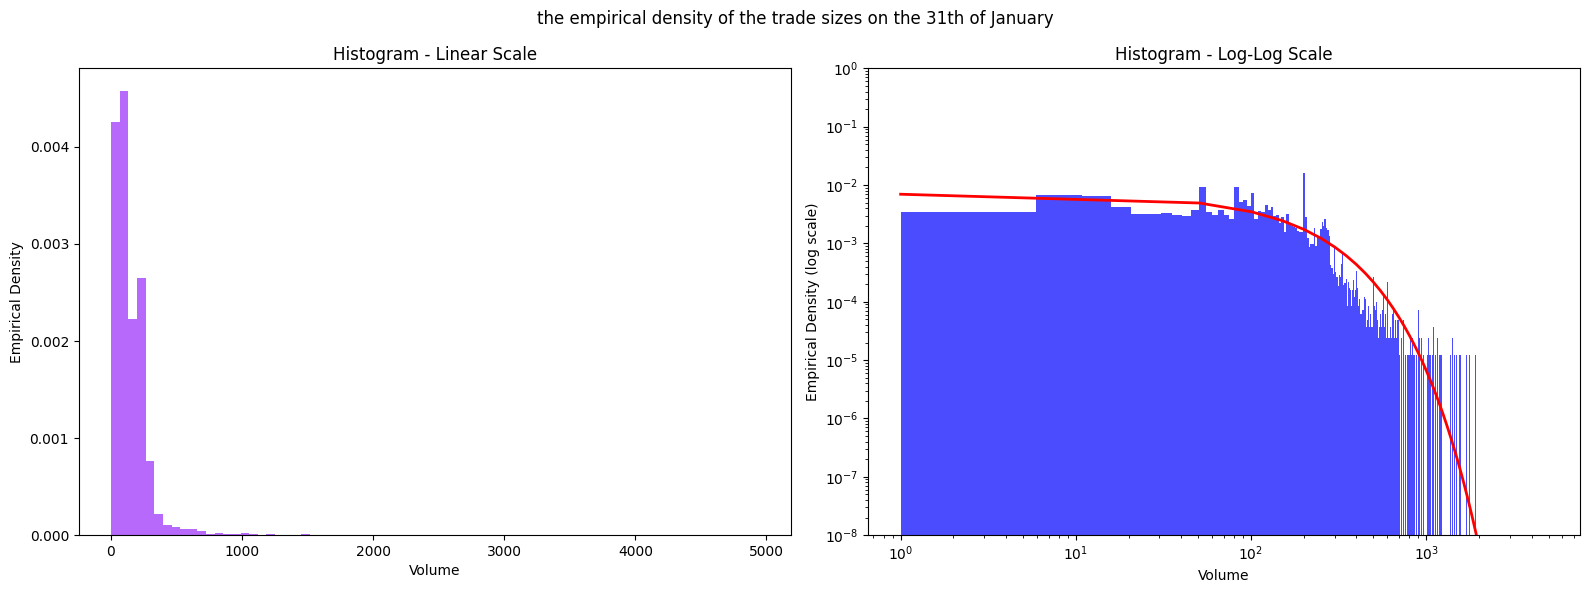

In [26]:
df_volume = df.copy()
#df_volume = df_volume.groupby(by=['ts']).agg(volume = ('volume','sum'))
#df_volume.reset_index()
Volume = df_volume['volume'].values


fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle(r'the empirical density of the trade sizes on the 31th of January')


ax[0].hist(Volume, bins=75, density=True, color='#972AF8', alpha=0.7)
ax[0].set_title('Histogram - Linear Scale')
ax[0].set_xlabel('Volume')
ax[0].set_ylabel('Empirical Density')


params= expon.fit(Volume)
xmin, xmax = np.min(Volume), np.max(Volume)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

ax[1].hist(Volume, bins=1000, density=True, log=True, color='blue', alpha=0.7)
ax[1].plot(x, p, linewidth=2,color='red',label=' exponential fit')
ax[1].set_xscale('log')
ax[1].set_title('Histogram - Log-Log Scale')
ax[1].set_xlabel('Volume')
ax[1].set_ylabel('Empirical Density (log scale)')
ax[1].set_ylim(1e-8, 1)

plt.tight_layout()
plt.show()

Calculating best minimal value for power law fit
C:\Users\mohamed iyadh laouej\AppData\Roaming\Python\Python39\site-packages\powerlaw.py:692: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


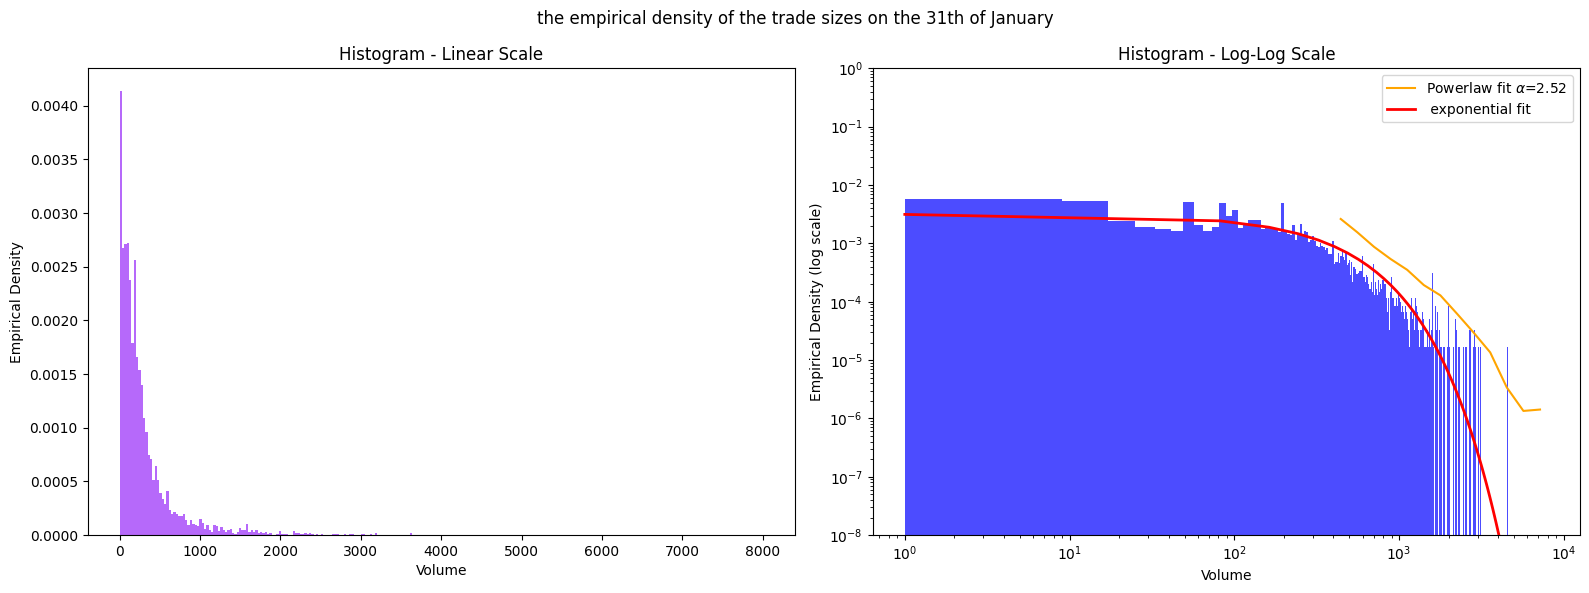

In [43]:
df_volume = df.copy()
df_volume = df_volume.groupby(by=['ts']).agg(volume = ('volume','sum'))
df_volume.reset_index()
Volume = df_volume['volume'].values


fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle(r'the empirical density of the trade sizes on the 31th of January')


ax[0].hist(Volume, bins=275, density=True, color='#972AF8', alpha=0.7)
ax[0].set_title('Histogram - Linear Scale')
ax[0].set_xlabel('Volume')
ax[0].set_ylabel('Empirical Density')


params= expon.fit(Volume)
xmin, xmax = np.min(Volume), np.max(Volume)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

fit = pl.Fit(Volume)
fit.plot_pdf(color='orange', ax=ax[1],label=r'Powerlaw fit $\alpha$='+f'{fit.power_law.alpha:.2f}')


ax[1].hist(Volume, bins=1000, density=True, log=True, color='blue', alpha=0.7)
ax[1].plot(x, p, linewidth=2,color='red',label=' exponential fit')
ax[1].set_xscale('log')
ax[1].set_title('Histogram - Log-Log Scale')
ax[1].set_xlabel('Volume')
ax[1].set_ylabel('Empirical Density (log scale)')
ax[1].set_ylim(1e-8, 1)
ax[1].legend()

plt.tight_layout()
plt.show()

In [28]:
alpha = fit.power_law.alpha # tail exponent of the fitter powerlaw
print('alpha:', alpha)


alpha: 2.515279139020438


value of alpha found is 2.51  which is the same value  2.5 listed in several studies.

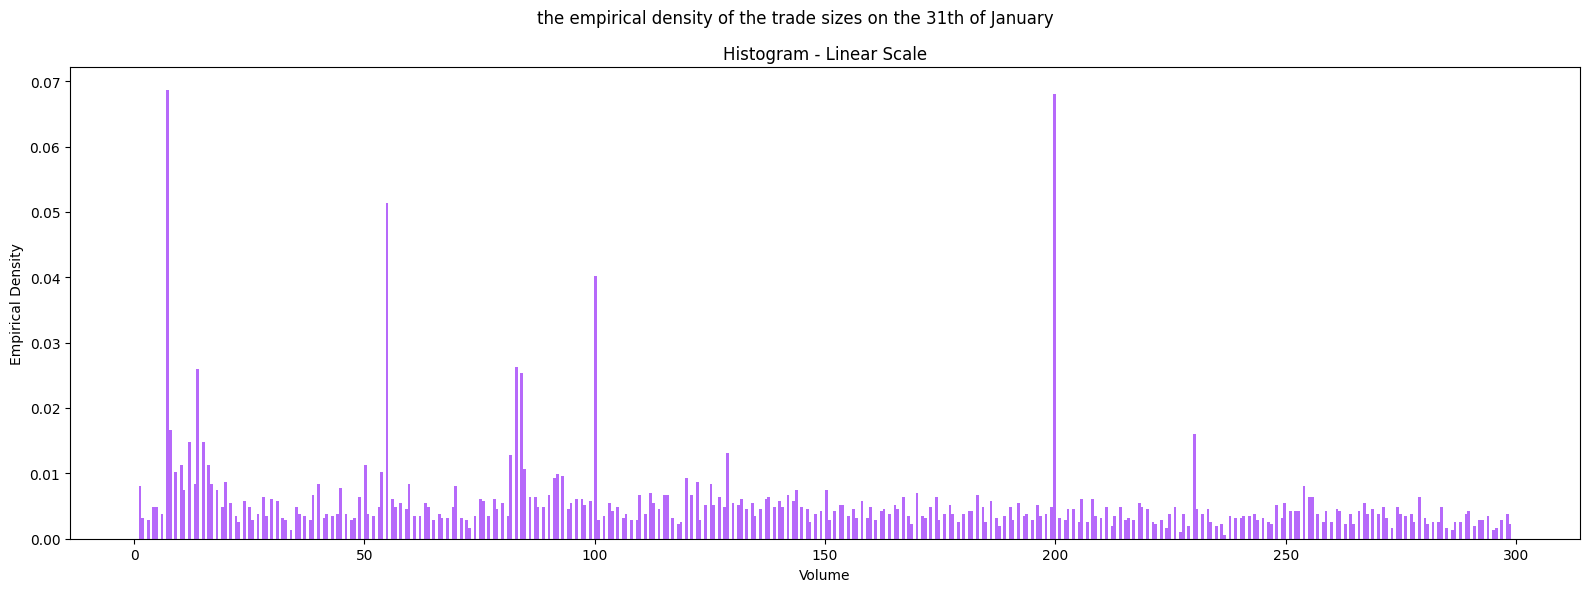

In [29]:
df_volume = df.copy()
df_volume = df_volume.groupby(by=['ts']).agg(volume = ('volume','sum'))
df_volume.reset_index()
Volume = df_volume['volume'].values


fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the trade sizes on the 31th of January')


ax.hist(Volume[Volume<300], bins=500, density=True, color='#972AF8', alpha=0.7)
ax.set_title('Histogram - Linear Scale')
ax.set_xlabel('Volume')
ax.set_ylabel('Empirical Density')


plt.tight_layout()
plt.show()

#### 4. High-frequency log-returns

4.1 Plot the complementary cumulative empirical distribution function of the normalized absolute
log-returns sampled every 1, 5, 15 and 30 minutes in semi-log scale. Add a Gaussian
reference to the plot. Comment.

4.2 [5] suggests that log-returns in event time are Gaussian.

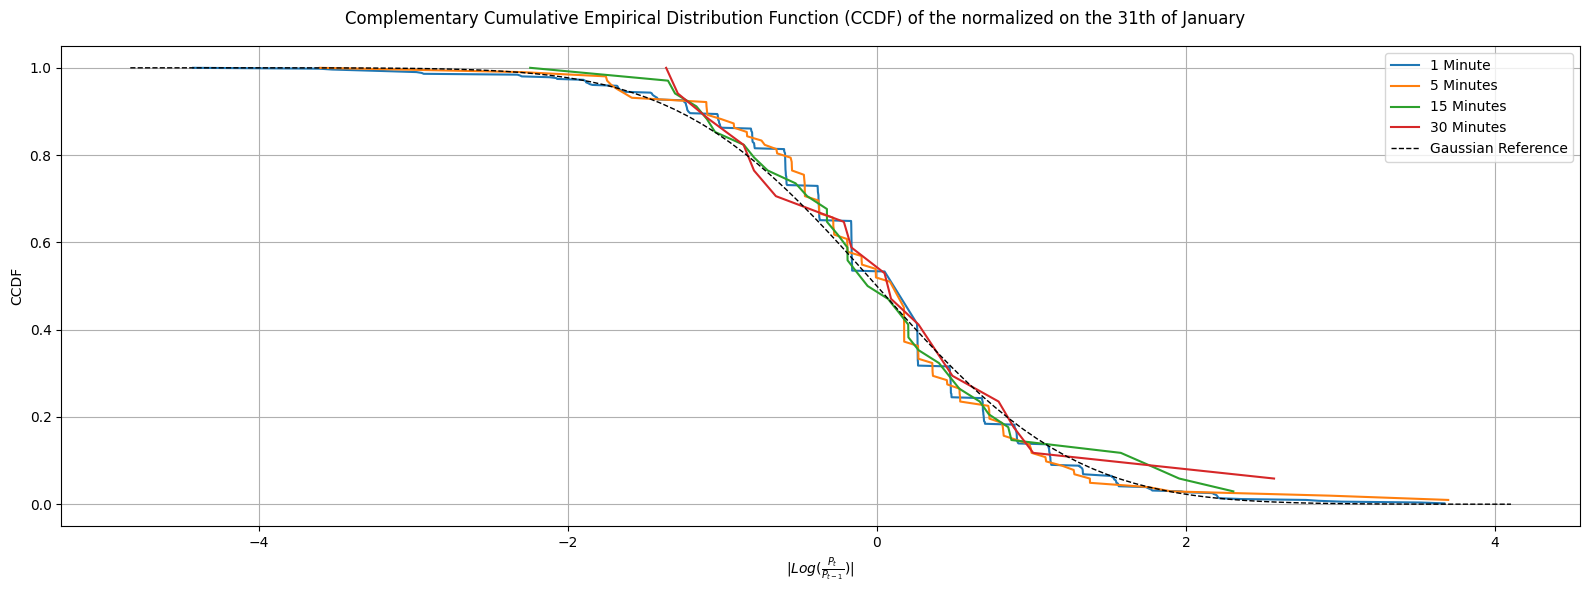

In [30]:
df_log_returns = df.copy()
df_log_returns.set_index('ts', inplace=True)


log_returns_1min = df_log_returns['price'].resample('1min').last().pct_change().apply(lambda x: 0 if pd.isna(x) else np.log(1 + x))#.abs()
log_returns_5min = df_log_returns['price'].resample('5min').last().pct_change().apply(lambda x: 0 if pd.isna(x) else np.log(1 + x))#.abs()
log_returns_15min = df_log_returns['price'].resample('15min').last().pct_change().apply(lambda x: 0 if pd.isna(x) else np.log(1 + x))#.abs()
log_returns_30min = df_log_returns['price'].resample('30min').last().pct_change().apply(lambda x: 0 if pd.isna(x) else np.log(1 + x))#.abs()


# Normalize the data using z-score normalization
normalized_1min = (log_returns_1min - log_returns_1min.mean()) / log_returns_1min.std()
normalized_5min = (log_returns_5min - log_returns_5min.mean()) / log_returns_5min.std()
normalized_15min = (log_returns_15min - log_returns_15min.mean()) / log_returns_15min.std()
normalized_30min = (log_returns_30min - log_returns_30min.mean()) / log_returns_30min.std()

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Complementary Cumulative Empirical Distribution Function (CCDF) of the normalized on the 31th of January')

# 1 minutes
sorted_data_1min = normalized_1min.sort_values(ascending=False)
ccdf_1min = sorted_data_1min.rank(ascending=False, method='max') / len(sorted_data_1min)
ax.plot(sorted_data_1min, ccdf_1min, label='1 Minute')

# 5 minutes
sorted_data_5min = normalized_5min.sort_values(ascending=False)
ccdf_5min = sorted_data_5min.rank(ascending=False, method='max') / len(sorted_data_5min)
ax.plot(sorted_data_5min, ccdf_5min, label='5 Minutes')

# 15 minutes
sorted_data_15min = normalized_15min.sort_values(ascending=False)
ccdf_15min = sorted_data_15min.rank(ascending=False, method='max') / len(sorted_data_15min)
ax.plot(sorted_data_15min, ccdf_15min, label='15 Minutes')

# 30 minutes
sorted_data_30min = normalized_30min.sort_values(ascending=False)
ccdf_30min = sorted_data_30min.rank(ascending=False, method='max') / len(sorted_data_30min)
ax.plot(sorted_data_30min, ccdf_30min, label='30 Minutes')

# Add Gaussian reference
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = 0, 1
p = 1- norm.cdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=1, linestyle='--', label='Gaussian Reference')

ax.legend()
ax.grid()
ax.set_xlabel(r'$|Log(\frac{P_t}{P_{t-1}})|$')
ax.set_ylabel('CCDF')

plt.tight_layout()
plt.show()

* Comments
    - we notice that log-returns in event time are Gaussian

#### 5. Volatility in high-frequency

5.1 Compute the volatility signature plot of the transaction price.

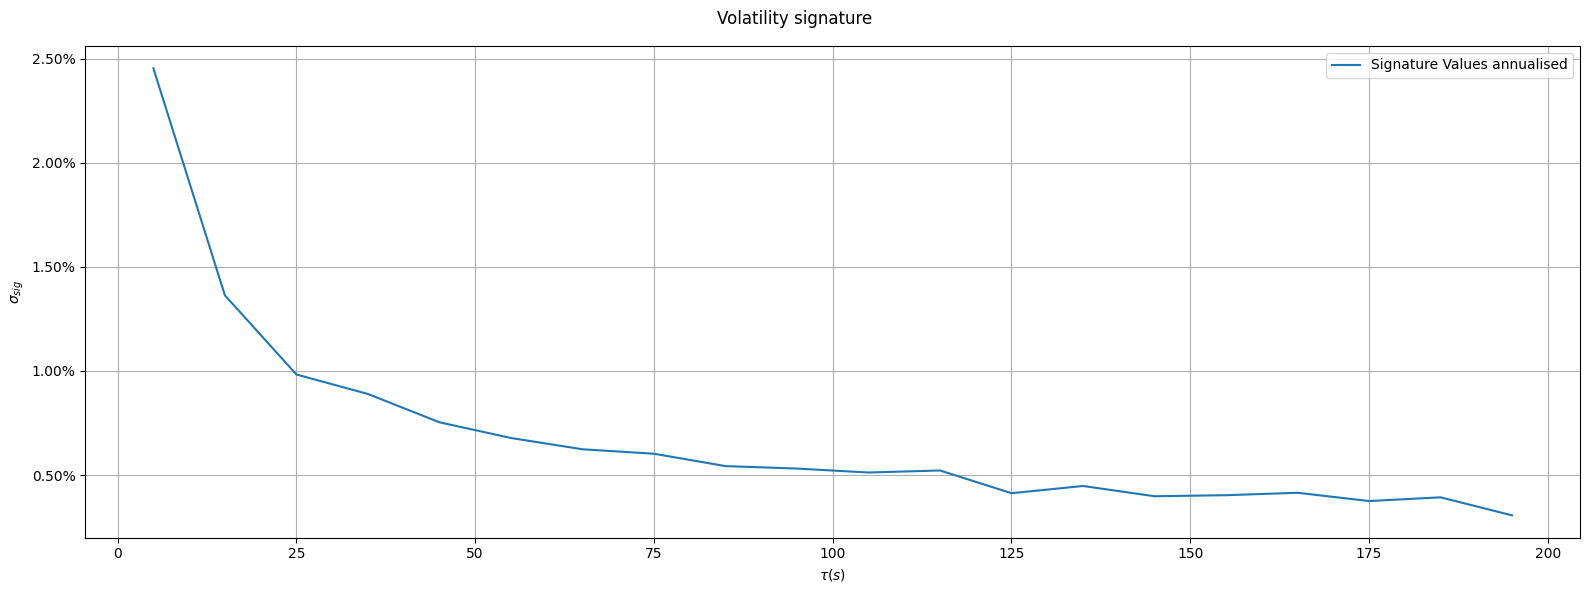

In [31]:
df_vol_signature = df.copy()                   #.iloc[:,len(df_trades)//10]
df_vol_signature.set_index('ts', inplace=True)

vol_signature_values = []
taux = np.arange(5,200,10)
Coef = 8*3600
for t in taux:
    index = str(int(t))+'s'
    vol_signature = np.log(df_vol_signature['price']).resample(index).last().ffill()
    Value = (((vol_signature - vol_signature.shift(1)).dropna())**2).sum()
    Value = np.sqrt(Coef/t)*Value
    vol_signature_values.append(Value)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Volatility signature')

ax.plot(taux, vol_signature_values, label='Signature Values annualised')

ax.legend()
ax.grid()
ax.set_xlabel(r'$\tau(s)$')
ax.set_ylabel(r'$\sigma_{sig}$')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.tight_layout()
plt.show()

* Comments:
    - we observe that the volatility diverges when the $\tau$ becomes small